In [1]:
import os
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
from sklearn.model_selection import train_test_split
from datasets import fake_br_corpus

In [3]:
import mlflow
# mlflow.sklearn.autolog()

In [4]:
dataset = fake_br_corpus.loadTrain()

/home/afsm/git/tmp/fake-news-detection/.venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
dataset.label.value_counts()

true    3073
fake    3047
Name: label, dtype: int64

In [6]:
for category in dataset.category.unique():
    print('========', category, '========')
    print(dataset[dataset.category == category].label.value_counts())

======== politica ========
true    1767
fake    1759
Name: label, dtype: int64
======== tv_celebridades ========
true    663
fake    659
Name: label, dtype: int64
======== sociedade_cotidiano ========
true    552
fake    541
Name: label, dtype: int64
======== economia ========
true    19
fake    19
Name: label, dtype: int64
======== ciencia_tecnologia ========
true    50
fake    48
Name: label, dtype: int64
======== religiao ========
true    22
fake    21
Name: label, dtype: int64


In [7]:
train, test = train_test_split(dataset, test_size=0.25, stratify=dataset.label)

In [8]:
train.label.value_counts()

/home/afsm/git/tmp/fake-news-detection/.venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


true    2305
fake    2285
Name: label, dtype: int64

In [9]:
test.label.value_counts()

true    768
fake    762
Name: label, dtype: int64

In [10]:
dataset.category.value_counts()

politica               3526
tv_celebridades        1322
sociedade_cotidiano    1093
ciencia_tecnologia       98
religiao                 43
economia                 38
Name: category, dtype: int64

# Preprocessing

In [11]:
import spacy
from spacy.lang.pt import STOP_WORDS

In [12]:
nlp = spacy.load('pt')
def lemmatize(text):
    global tokens
    tokens = nlp(text)
    lemmas = [token.lemma_ for token in tokens]
    return ' '.join(lemmas)

def cleanText(text):
    text = re.sub(r'[0-9"\(\)\,\:]+', ' ', text)
    text = re.sub(r'[\n ]+', ' ', text)
    text = text.lower()
    return text

def preprocess(text):
#     text = lemmatize(text)
    text = cleanText(text)
    return text

/home/afsm/git/tmp/fake-news-detection/.venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Feature extraction

In [160]:
import nltk
stopwords = nltk.corpus.stopwords.words('portuguese')

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [118]:
tfidf = TfidfVectorizer(
    preprocessor=preprocess,
    stop_words=stopwords,
    strip_accents='unicode',
    ngram_range=(1,3),
    max_features=1000
)

In [119]:
X = tfidf.fit_transform(train.text)

# Classification

In [135]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [121]:
clf1 = SVC(probability=True)
clf1.fit(X, train.label)

SVC(probability=True)

In [122]:
clf2 = DecisionTreeClassifier()
clf2.fit(X, train.label)

DecisionTreeClassifier()

In [136]:
clf3 = MultinomialNB()
clf3.fit(X, train.label)

MultinomialNB()

In [137]:
X_test = tfidf.transform(test.text)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [138]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline
def evaluate(clf, X_test, ytrue):
    ypred = clf.predict(X_test)
    accuracy = accuracy_score(ytrue, ypred)
    estimator_class = str(type(clf)).split("'")[-2]
    estimator_name = estimator_class.split('.')[-1]
    print(classification_report(ytrue, ypred))
    print('accuracy:', accuracy)
    with mlflow.start_run() as run:
        mlflow.log_params(clf.get_params())
        mlflow.log_metric('validation_accuracy_score', accuracy)
        mlflow.set_tags(dict(estimator_class=estimator_class, estimator_name=estimator_name))
        train[['id']].to_csv('/tmp/trained_with.csv', index=False)
        mlflow.log_artifact('/tmp/trained_with.csv')
        mlflow.sklearn.log_model(
            make_pipeline(tfidf, clf),
            'model'
        )
    return ypred

In [129]:
ypred1 = evaluate(clf1, X_test, test.label)

              precision    recall  f1-score   support

        fake       0.96      0.97      0.97       762
        true       0.97      0.96      0.97       768

    accuracy                           0.97      1530
   macro avg       0.97      0.97      0.97      1530
weighted avg       0.97      0.97      0.97      1530

accuracy: 0.9673202614379085


In [126]:
ypred2 = evaluate(clf2, X_test, test.label)

              precision    recall  f1-score   support

        fake       0.88      0.88      0.88       762
        true       0.88      0.88      0.88       768

    accuracy                           0.88      1530
   macro avg       0.88      0.88      0.88      1530
weighted avg       0.88      0.88      0.88      1530

accuracy: 0.8823529411764706


In [139]:
ypred3 = evaluate(clf3, X_test, test.label)

              precision    recall  f1-score   support

        fake       0.90      0.81      0.85       762
        true       0.83      0.91      0.87       768

    accuracy                           0.86      1530
   macro avg       0.86      0.86      0.86      1530
weighted avg       0.86      0.86      0.86      1530

accuracy: 0.8581699346405228


In [34]:
infos = mlflow.list_run_infos('0')
info = infos[0]

/home/afsm/git/tmp/fake-news-detection/.venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
pd.DataFrame([{ k[1:]: v for k, v in info.__dict__.items() } for info in infos])

/home/afsm/git/tmp/fake-news-detection/.venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,run_uuid,run_id,experiment_id,user_id,status,start_time,end_time,lifecycle_stage,artifact_uri
0,054ef7280e09494081866fd90130f1b4,054ef7280e09494081866fd90130f1b4,0,afsm,FINISHED,1608392103834,1608392121581,active,./mlruns/0/054ef7280e09494081866fd90130f1b4/ar...
1,43508605c1a443639a3f8d87d424e3d3,43508605c1a443639a3f8d87d424e3d3,0,afsm,FINISHED,1608392087685,1608392103708,active,./mlruns/0/43508605c1a443639a3f8d87d424e3d3/ar...


In [60]:
model = mlflow.sklearn.load_model(os.path.join(info.artifact_uri, 'model'))

In [98]:
text = 'como a deputada estadual, apalpada por um colega no plenário da Assembleia Legislativa de São Paulo, outras quatro deputadas federais relataram à Folha que já foram assediadas no exercício de suas funções. As mulheres representam 15% dos integrantes da Câmara dos Deputados, composta em sua maioria por homens brancos. No Código Penal, os fatos narrados poderiam ser enquadrados como importunação sexual, crime que prevê de um a cinco anos de reclusão. Isa Penna (PSOL) registrou um boletim de ocorrência contra o deputado Fernando Cury (Cidadania) e também levou ao Conselho de Ética da Assembleia uma representação pedindo que ele perca o mandato.'

In [99]:
model.predict([text])

array(['fake'], dtype=object)

In [102]:
import eli5
eli5.show_weights(clf2, vec=tfidf, top=20, target_names=clf2.classes_)

Weight,Feature
0.4030,segundo
0.1460,feira
0.0727,sem
0.0378,as
0.0257,nesta
0.0229,no
0.0151,geral
0.0144,ao
0.0113,sempre
0.0110,por exemplo


In [101]:
eli5.show_prediction(clf2, text, vec=tfidf, target_names=clf2.classes_)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [24]:
def resultsPerCategory(ypred):
    for category in test.category.unique():
        print('========', category, '========')
        print(classification_report(test.label[test.category == category], ypred[test.category == category]))

In [27]:
resultsPerCategory(ypred2)

======== politica ========
              precision    recall  f1-score   support

        fake       0.91      0.91      0.91       433
        true       0.91      0.91      0.91       442

    accuracy                           0.91       875
   macro avg       0.91      0.91      0.91       875
weighted avg       0.91      0.91      0.91       875

======== sociedade_cotidiano ========
              precision    recall  f1-score   support

        fake       0.87      0.89      0.88       130
        true       0.91      0.89      0.90       153

    accuracy                           0.89       283
   macro avg       0.89      0.89      0.89       283
weighted avg       0.89      0.89      0.89       283

======== tv_celebridades ========
              precision    recall  f1-score   support

        fake       0.92      0.90      0.91       177
        true       0.89      0.91      0.90       151

    accuracy                           0.91       328
   macro avg       0.90      

In [28]:
test.category.value_counts()

politica               875
tv_celebridades        328
sociedade_cotidiano    283
ciencia_tecnologia      25
economia                10
religiao                 9
Name: category, dtype: int64

In [30]:
import mlflow
import modellogger

/home/afsm/git/tmp/fake-news-detection/.venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
mlflow.end_run

In [32]:
from modellogger.modellogger import ModelLogger

#initialise a modelloger instance
path = "./databasename.db"
mlog = ModelLogger(path) #setup complete

/home/afsm/git/tmp/fake-news-detection/.venv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Setup Completed 


In [34]:
mlog.store_model(clf1, 'SVC', X, 0.9562091503267974)

Model is not compatable with Modelloger - /n consult the help() section 


/home/afsm/git/tmp/fake-news-detection/.venv/lib/python3.7/site-packages/modellogger/modellogger.py:128: UserWarning: Model Unparseable Error - possible reasons /n 1. Passed object is not a model /n 2.Model is not fitted /nModel is not compatable with modelloger /n Check the docs to know more
  warnings.warn("Model Unparseable Error - possible reasons /n 1. Passed object is not a model /n 2.Model is not fitted /nModel is not compatable with modelloger /n Check the docs to know more")


AttributeError: columns not found

In [28]:
tfidf.transform(train.text)

<4590x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 690534 stored elements in Compressed Sparse Row format>

---

In [54]:
testNumWords = test.text.apply(lambda text: len(preprocess(text).split())).values

In [73]:
binYpred = np.where(ypred2 == 'fake', 1, 0)
binYtrue = np.where(test.label == 'fake', 1, 0)

In [66]:
proba2 = clf2.predict_proba(X_test)

In [96]:
df = pd.DataFrame({'pred': binYpred, 'true':binYtrue, 'wordCount':testNumWords})
# df = pd.DataFrame({'pred':ypred2, 'true':test.label, 'wordCount':testNumWords})
df0 = df[df.true == 0]
df1 = df[df.true == 1]

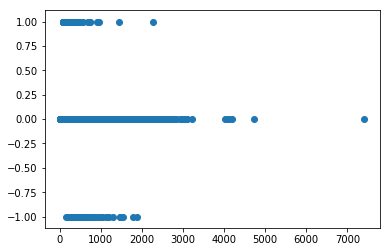

In [105]:
# plt.scatter(testNumWords, proba2.T[0])
# plt.scatter(testNumWords, binYtrue)
plt.scatter(df.wordCount, df.true - df.pred)

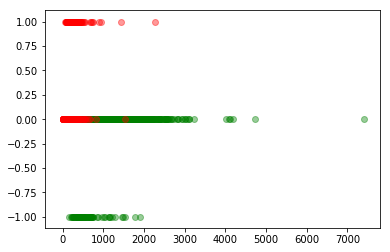

In [106]:
plt.scatter(df0.wordCount, df0.true - df0.pred, alpha=0.4, c='g')
plt.scatter(df1.wordCount, df1.true - df1.pred, alpha=0.4, c='r')